In [42]:
!pip install wandb
!pip install accelerate
!pip install bert_score
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 8.0 MB/s eta 0:00:00


In [2]:
# download hugging face datasets
import datasets 
from datasets import concatenate_datasets
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sentencepiece
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import torch
import transformers
from datasets import load_dataset, load_metric
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer,DataCollatorForSeq2Seq,AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import wandb



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2024-03-28 05:54:24.227581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 05:54:24.227683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 05:54:24.342776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_Data = datasets.load_dataset("wmt16","de-en", split="train[:50000]")
val_Data = datasets.load_dataset("wmt16","de-en", split="validation")
test_Data = datasets.load_dataset("wmt16","de-en", split="test")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Dataset wmt16 downloaded and prepared to /root/.cache/huggingface/datasets/wmt16/de-en/1.0.0/9e0038fe4cc117bd474d2774032cc133e355146ed0a47021b2040ca9db4645c0. Subsequent calls will reuse this data.


### Loading the model

In [4]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
source_lang = "de" 
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [6]:
pt_data = train_Data.map(preprocess_function, batched=True)
pt_data_v = val_Data.map(preprocess_function, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

  0%|          | 0/50 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?ba/s]

In [7]:
model_config = dict(task = "2C",
                    model_name = "t5-small",
                    learning_rate = 2e-5,
                    per_device_train_batch_size = 16,
                    per_device_eval_batch_size = 16,
                    weight_decay = 0.01,
                    num_train_epochs = 5,
)
wandb.login(relogin=True)
# Initialize wandb
wandb.init(project="assignment-3", entity="nlp-assignments", name="t5-small_task2C_final_run", config=model_config)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vartika21571 (nlp-assignments). Use `wandb login --relogin` to force relogin


In [8]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    report_to="wandb",
    logging_dir='./logs',
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=pt_data,
    eval_dataset=pt_data_v,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
trainer.save_model("fine_tuned_t5_small_task2C")

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.369900,2.119353
2,2.267500,2.074616
3,2.213600,2.051635
4,2.181400,2.041315
5,2.175500,2.038529


In [12]:
print(trainer.state)

TrainerState(epoch=5.0, global_step=15625, max_steps=15625, logging_steps=500, eval_steps=500, save_steps=500, train_batch_size=16, num_train_epochs=5, num_input_tokens_seen=0, total_flos=6718371254501376.0, log_history=[{'loss': 2.8011, 'grad_norm': 1.863675832748413, 'learning_rate': 1.936256e-05, 'epoch': 0.16, 'step': 500}, {'loss': 2.5593, 'grad_norm': 2.001554489135742, 'learning_rate': 1.872256e-05, 'epoch': 0.32, 'step': 1000}, {'loss': 2.4915, 'grad_norm': 1.8123807907104492, 'learning_rate': 1.8082560000000003e-05, 'epoch': 0.48, 'step': 1500}, {'loss': 2.4401, 'grad_norm': 3.2305569648742676, 'learning_rate': 1.7442560000000002e-05, 'epoch': 0.64, 'step': 2000}, {'loss': 2.4145, 'grad_norm': 2.400637149810791, 'learning_rate': 1.680256e-05, 'epoch': 0.8, 'step': 2500}, {'loss': 2.3699, 'grad_norm': 1.8922754526138306, 'learning_rate': 1.616256e-05, 'epoch': 0.96, 'step': 3000}, {'eval_loss': 2.1193532943725586, 'eval_runtime': 4.6487, 'eval_samples_per_second': 466.587, 'eva

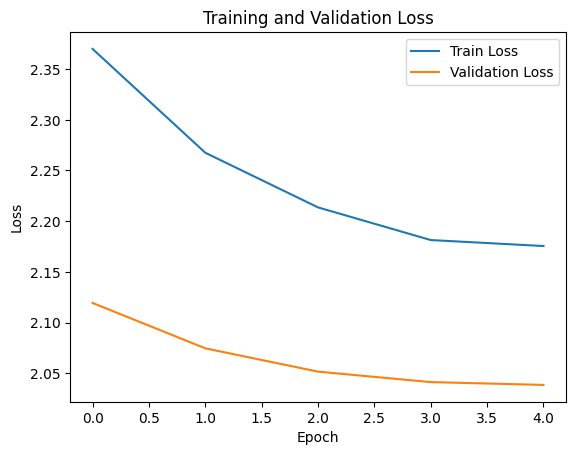

In [39]:
import matplotlib.pyplot as plt

train_loss_indexes = []
train_loss = []
eval_loss = []
for i in range(len(trainer.state.log_history)):
    if "eval_loss" in trainer.state.log_history[i].keys():
        if trainer.state.log_history[i]['epoch']==1 or trainer.state.log_history[i]['epoch']==2 or trainer.state.log_history[i]['epoch']==3 or trainer.state.log_history[i]['epoch']==4 or trainer.state.log_history[i]['epoch']==5: 
            train_loss_indexes.append(i-1)
        
for i in range(5):
    train_loss.append(trainer.state.log_history[train_loss_indexes[i]]['loss'])
    eval_loss.append(trainer.state.log_history[train_loss_indexes[i]+1]['eval_loss'])
# print(train_loss)
# print(eval_loss)



# Plot the graph
plt.plot(train_loss ,label='Train Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [40]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Check memory usage
allocated_memory = torch.cuda.memory_allocated()
reserved_memory = torch.cuda.memory_reserved()

print("Allocated Memory:", allocated_memory / 1024**3, "GiB")
print("Reserved Memory:", reserved_memory / 1024**3, "GiB")

Allocated Memory: 0.6920843124389648 GiB
Reserved Memory: 0.822265625 GiB


### Testing 

In [43]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset, load_metric
from tqdm import tqdm

# Load the fine-tuned model
model_path = "/kaggle/working/fine_tuned_t5_small_task2C"  # Path to the saved fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Load the test dataset
test_dataset = load_dataset("wmt16", "de-en", split="test")

# Define the BLEU metric
bleu_metric = load_metric("sacrebleu")

# Generate translations for the test dataset
translations = []
references = []
for example in tqdm(test_dataset):
    input_text = "translate German to English: " + example["translation"]["de"]
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    translated_ids = model.generate(input_ids, max_length=512, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    translations.append(translated_text)
    references.append(example["translation"]["en"])



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 2999/2999 [14:56<00:00,  3.34it/s] 


ValueError: Got a string but expected a list instead: 'Obama receives Netanyahu'

In [50]:
!pip install --upgrade nltk

import nltk
nltk.download('wordnet')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
bleu_score_testing = corpus_bleu([[ref] for ref in references], translations)

print("BLEU score for testing set:", bleu_score_testing)



# meteor = datasets.load_metric("meteor")
# meteor_score = meteor.compute(predictions=translations, references=references)
# print("METEOR score for testing set:", meteor_score)


from bert_score import score
P, R, F1 = score(translations, references, lang="de", verbose=True)
print("BERT Score for validation set:", F1.mean().item())

BLEU score for testing set: 0.588957331069719


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/94 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/47 [00:00<?, ?it/s]

done in 11.23 seconds, 266.99 sentences/sec
BERT Score for validation set: 0.8356908559799194


In [53]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True